In [ ]:
!pip install gym_super_mario_bros==7.3.0 nes_py --user

In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [3]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env,SIMPLE_MOVEMENT)

In [4]:
SIMPLE_MOVEMENT[env.action_space.sample()]

['right', 'A']

In [ ]:
done = True
#Loop through each frame
for step in range(100000):
    if done:
        #Start the game
        env.reset()
    #Random action
    state,reward,done,info = env.step(env.action_space.sample())
    env.render()
env.close()

# 1. Preprocessing

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117 --user

In [5]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [6]:
#1. Create Base env
env = gym_super_mario_bros.make('SuperMarioBros-v0')
#2. Simplify controls
env = JoypadSpace(env,SIMPLE_MOVEMENT)
#3 Grayscale env
env = GrayScaleObservation(env, keep_dim=True) # Keep on true for frame stacking
#4. Wrap inside Dummy env
env = DummyVecEnv([lambda: env])
#5 Stack frames
env = VecFrameStack(env,4,channels_order='last')

In [7]:
state = env.reset()

In [8]:
state.shape

(1, 240, 256, 4)

In [9]:
state,reward,done,info = env.step([env.action_space.sample()])

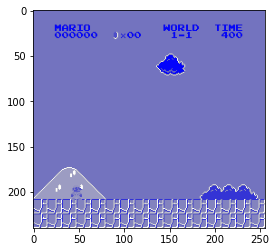

In [10]:
plt.imshow(state.squeeze())

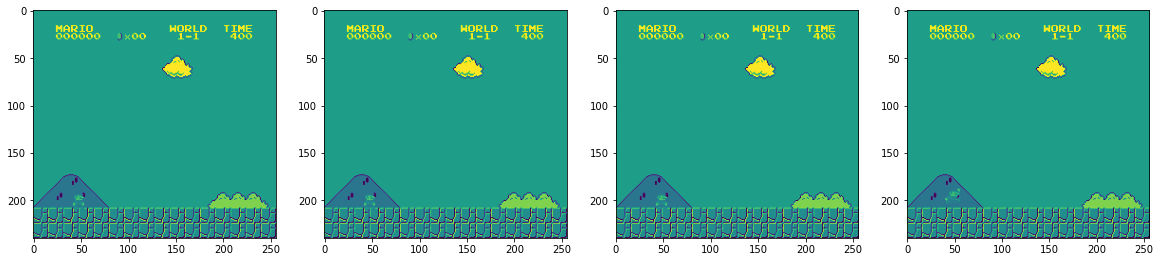

In [17]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3.Train RL model

In [11]:
#Import PPO for algorithms and Base callback for saving models
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [12]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self,check_freq,save_path,verbose = 1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path,exist_ok = True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [13]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [21]:
#Model saving callback function
callback = TrainAndLoggingCallback(check_freq = 10000, save_path = CHECKPOINT_DIR)

In [22]:
#AI model using PPO
model = PPO('CnnPolicy',env, verbose = 1, tensorboard_log=LOG_DIR,learning_rate = 0.000001, n_steps =512) # MlpPolicy for tabular data

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
#Train AI model
model.learn(total_timesteps=100000, callback=callback)

In [ ]:
# Save model
#model.save('thisisatestmodel')

In [14]:
# Load model
model = PPO.load('./train/best_model_700000')

FileNotFoundError: [Errno 2] No such file or directory: 'train\\best_model_700000.zip'

In [25]:
state = env.reset()
while True:
    action, _ = model.predict(state)
    state,reward,done,info = env.step(action)
    env.render()

C:\Anaconda\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] No se puede cambiar el modo de subproceso después de establecerlo
  warnings.warn(str(err))
C:\Users\ÓscarLópezMontero\AppData\Roaming\Python\Python39\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

In [ ]:
env.close()